<h1> MobileNet V2 Shot-Framing Detector

In this notebook, the goal was to set a baseline -- no extra data augmentations, no `mixup`, no mixed precision  training, no progressive image resizing, and no _unfreezing_ was done.

With nothing fancy going on, `MobileNetV2` beat the previous best model -- a ResNet-50, achieving 94+ % accuracy. We're gonna need a tougher validation set going forward.

## Setup

In [1]:
#default_exp train_utils

In [2]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
#export
from fastai.vision import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.metrics import accuracy, Precision, Recall
from CinemaNet.custom_head import *
import wandb
from wandb.fastai import WandbCallback

In [3]:
wandb.init(name='MobileNetV2',
           project='CinemaNet--Shot-Framing',
           tags=['MobileNetV2'])

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/rsomani95/CinemaNet--Shot-Framing/runs/gxboerv0

In [5]:
path = '/home/rahul/github_projects/CinemaNet/'

### Data Transformations

In [6]:
#export
to_film_ar = lambda h: (h, int(h * 16/9)) # h = height

def xtra_tfms(base_size): 
    box_dim = int(base_size/4)
    cutout_ = partial(cutout, p = .3, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = .3,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p=.3, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p=.3, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p=.3, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p=.3, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p=.3, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    #dihedral_  = partial(dihedral, ())
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

def get_tfms(base_size): return get_transforms(do_flip = True,
                                               flip_vert = False,
                                               max_zoom = 1.,
                                               max_lighting = 0.4,
                                               max_warp = 0.3,
                                               p_affine = 0.85,
                                               p_lighting = 0.85,
                                               xtra_tfms = xtra_tfms(base_size))

### Data Fetching, Metrics, Callbacks

In [7]:
#export
def get_data(path, base_size, batch_size, transforms=get_transforms(max_zoom=1.), **kwargs):
    return ImageDataBunch.from_folder(path, 'train', 'valid', 
                                      size    = to_film_ar(base_size),
                                      ds_tfms = transforms, bs=batch_size,
                                      resize_method = ResizeMethod.SQUISH,
                                      **kwargs
                                     ).normalize(imagenet_stats)

In [8]:
#export
metrics   = [accuracy, Precision(), Recall()]

# This callback won't be needed if using the `WandbCallback`
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy'),
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks


cb_wandb = partial(WandbCallback, 
                   log='all', 
                   monitor = 'accuracy',
                   input_type = 'images')

def cb_estop(learner, patience=5, min_delta=0.01, monitor='accuracy'):
    return EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor)

## Training

['Close-Up',
 'Extreme Close-Up',
 'Extreme Wide',
 'Long',
 'Medium',
 'Medium Close-Up']

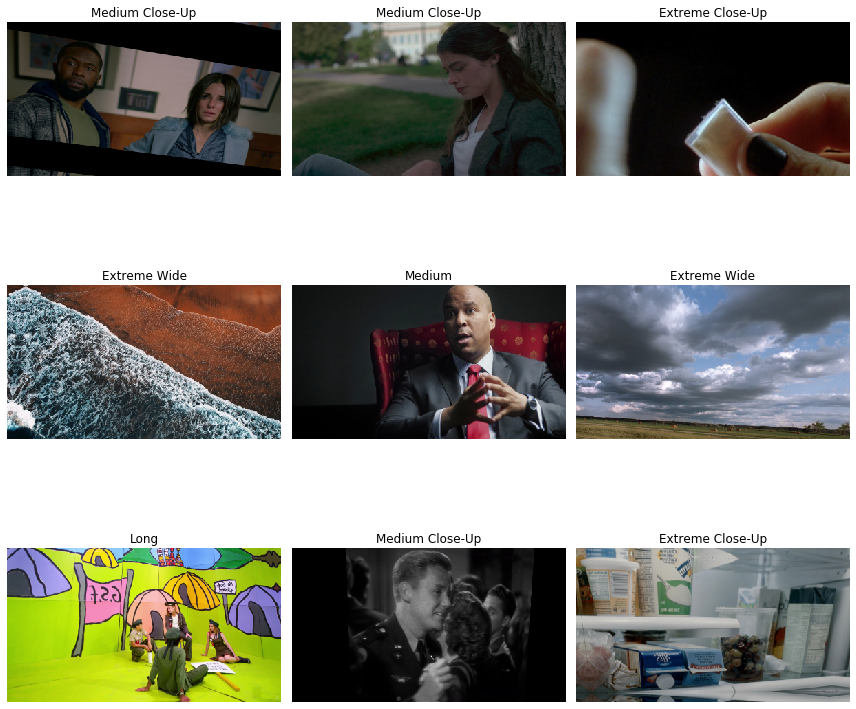

In [9]:
data = get_data(path, base_size=224, batch_size=32)
data.show_batch(rows=3)
data.classes

In [10]:
learn = cnn_learner(data, models.mobilenet_v2, pretrained=True,
                    metrics=metrics)

### Training The Head

In [11]:
model_name = 'MobileNetV2-img_224-frozen'
callbacks  = get_callbacks(learn, model_name)

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


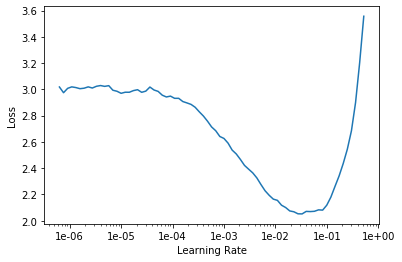

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.254497,0.522415,0.793333,0.804190,0.793333,01:16
1,0.752208,0.403973,0.868333,0.874974,0.868333,01:21
2,0.519410,0.305802,0.896667,0.896628,0.896667,01:23
3,0.452635,0.304312,0.900000,0.902235,0.900000,01:17
4,0.348646,0.211499,0.936667,0.938371,0.936667,01:04
5,0.288821,0.240398,0.920000,0.923224,0.920000,01:03
6,0.233371,0.201009,0.938333,0.939941,0.938333,01:03
7,0.198960,0.192865,0.943333,0.944025,0.943333,01:02
8,0.168566,0.197820,0.936667,0.938043,0.936667,01:06
9,0.153517,0.196930,0.943333,0.943950,0.943333,00:59


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7933333516120911.
Better model found at epoch 0 with valid_loss value: 0.5224151015281677.
Better model found at epoch 0 with accuracy value: 0.7933333516120911.
Better model found at epoch 1 with accuracy value: 0.8683333396911621.
Better model found at epoch 1 with valid_loss value: 0.4039729833602905.
Better model found at epoch 1 with accuracy value: 0.8683333396911621.
Better model found at epoch 2 with accuracy value: 0.8966666460037231.
Better model found at epoch 2 with valid_loss value: 0.3058023154735565.
Better model found at epoch 2 with accuracy value: 0.8966666460037231.
Better model found at epoch 3 with accuracy value: 0.8999999761581421.
Better model found at epoch 3 with valid_loss value: 0.3043116331100464.
Better model found at epoch 3 with accuracy value: 0.8999999761581421.
Better model found at epoch 4 with accuracy value: 0.9366666674613953.
Better model found at epoch 4 with valid_loss value: 0.21149857342243

### Interpret

In [14]:
interpret = ClassificationInterpretation.from_learner(learn)

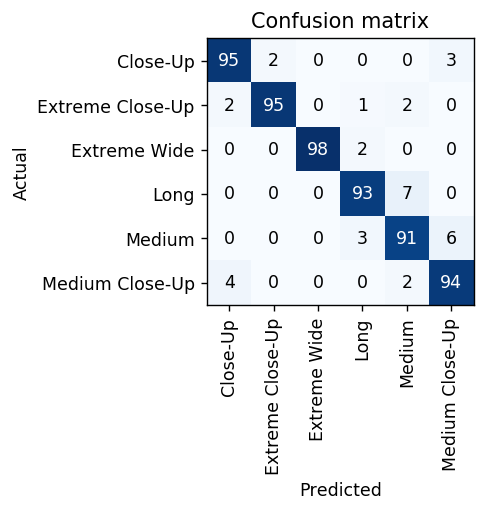

In [15]:
interpret.plot_confusion_matrix(dpi=125)

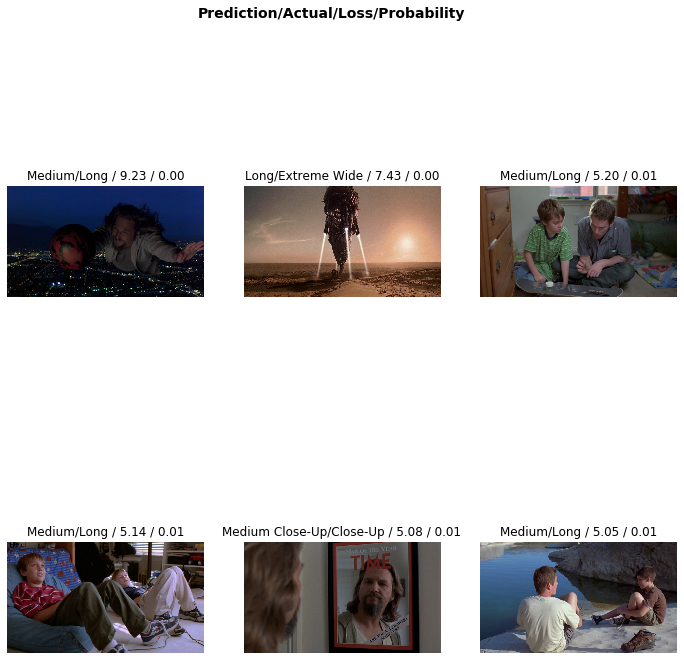

In [16]:
interpret.plot_top_losses(6)

---

### Export

In [7]:
#hide
from nbdev.export import *
notebook2script()

Converted fastai_custom_head.ipynb.
Converted mobilenet_v2_basic.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted pytorch_to_onnx.ipynb.
